# Modeling1-2_ARIMAX
* 증기압을 외부변수로 해서 기온을 예측하는 시계열 모델

> ARIMAX모델 세팅 시 exog(외부변수) 값 세팅
* train 시킬때는 exog값도 train과 동일한 범위를 넣고 학습시키고, <br>
forecast 할때는 예측할 시점의 exog값을 같이 넣어야 함.<br>
(ex. 0~500학습하고 501시점 예측한다면, 501시점의 exog값도 넣어야 함)
    * but, 대회 규칙상 예측하는 시점의 실제 기상정보는 활용할 수 없으므로 다른 방법 고민 필요.

> pyflux패키지 ARIMAX 와 tsa의 ARIMAX 두가지 활용

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [5]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 당진
# dangjin_humid=pd.read_csv('./data/dangjin_humid.csv',index_col=None)
# dangjin_rain=pd.read_csv('./data/dangjin_rain.csv',index_col=None)
# dangjin_tem=pd.read_csv('./data/dangjin_tem.csv',index_col=None)

# 신평
# shinpyung_humid=pd.read_csv('./data/shinpyung_humid.csv',index_col=None)
# shinpyung_rain=pd.read_csv('./data/shinpyung_rain.csv',index_col=None)
# shinpyung_tem=pd.read_csv('./data/shinpyung_tem.csv',index_col=None)

# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

# test데이터셋과 동일하게 train 데이터 전처리
# plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0])

In [8]:
# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])
seosan=seosan.rename(columns={'일시':'date','기온(°C)':'tem','습도(%)':'hum','이슬점온도(°C)':'dew','증기압(hPa)':'vapor'})

### 컬럼명 전처리

In [ ]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

### 기온, 습도, 이슬점온도 컬럼 분리

In [10]:
# 30분단위 추가 전
seosan_hum=seosan[['date','hum']]
seosan_dew=seosan[['date','dew']]
seosan_tem=seosan[['date','tem']]
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

### 30분 단위 추가

In [11]:
seosan.shape

(35198, 37)

In [12]:
index_30min=pd.date_range('2016-04-01 00:30:00', periods=35231, freq='H')
index_30min=index_30min.to_frame().rename(columns={0:'date'})
seosan2=pd.concat([seosan,index_30min],ignore_index=True)
seosan2=seosan2.sort_values('date').reset_index(drop=True)
seosan2=seosan2[['date','tem','hum','dew','vapor']]
seosan2

,date,tem,hum,dew,vapor
0,2016-04-01 00:00:00,8.8,41.0,-3.7,4.6
1,2016-04-01 00:30:00,NaN,NaN,NaN,NaN
2,2016-04-01 01:00:00,9.2,34.0,-5.8,4.0
3,2016-04-01 01:30:00,NaN,NaN,NaN,NaN
4,2016-04-01 02:00:00,9.2,33.0,-6.2,3.8
...,...,...,...,...,...
70424,2020-04-07 21:00:00,7.7,89.0,5.9,9.3
70425,2020-04-07 21:30:00,NaN,NaN,NaN,NaN
70426,2020-04-07 22:00:00,6.4,72.0,1.7,6.9
70427,2020-04-07 22:30:00,NaN,NaN,NaN,NaN


### 결측값 보간

In [13]:
seosan2=seosan2.interpolate()
seosan2

,date,tem,hum,dew,vapor
0,2016-04-01 00:00:00,8.80,41.0,-3.70,4.6
1,2016-04-01 00:30:00,9.00,37.5,-4.75,4.3
2,2016-04-01 01:00:00,9.20,34.0,-5.80,4.0
3,2016-04-01 01:30:00,9.20,33.5,-6.00,3.9
4,2016-04-01 02:00:00,9.20,33.0,-6.20,3.8
...,...,...,...,...,...
70424,2020-04-07 21:00:00,7.70,89.0,5.90,9.3
70425,2020-04-07 21:30:00,7.05,80.5,3.80,8.1
70426,2020-04-07 22:00:00,6.40,72.0,1.70,6.9
70427,2020-04-07 22:30:00,6.50,64.0,0.10,6.2


In [183]:
# 결측치 없는것 확인.
print('기온 결측치:',seosan_tem2.isnull().sum())
print('습도 결측치:',seosan_hum2.isnull().sum())
print('이슬점온도 결측치:',seosan_dew2.isnull().sum())

기온 결측치: date    0
tem     0
dtype: int64
습도 결측치: date    0
hum     0
dtype: int64
이슬점온도 결측치: date    0
dew     0
dtype: int64


### 30분단위 추가 후  기온, 습도, 이슬점온도 분류

In [14]:
# 30분단위 추가 후  기온, 습도, 이슬점온도 분류
seosan_hum2=seosan2[['date','hum']]
seosan_dew2=seosan2[['date','dew']]
seosan_tem2=seosan2[['date','tem']]
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

In [15]:
seosan_tem2.head()

,date,tem
0,2016-04-01 00:00:00,8.8
1,2016-04-01 00:30:00,9.0
2,2016-04-01 01:00:00,9.2
3,2016-04-01 01:30:00,9.2
4,2016-04-01 02:00:00,9.2


------------------------------------------------------------------------------------------------------------------------------------------------
## ARIMAX
[참고] http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels <br>
* statsmodels의 시계열 모형 클래스 ARMA, ARIMA, SARIMAX 등은 모두 외부 시계열의 영향을 포함하기 위한 exog 라는 인수를 가지고 있다.<br>
    이 인수가 주어지면 기존의 모형에 외부 시계열에 대한 선형 회귀항이 포함된다.
* model의 모든 variable이 stationary해야 한다. 

In [16]:
def get_time_delta(data, hour_,minute_):
    """
    시간, 분 지정하면 해당 시간대만 가져오도록
    """
    data['hour']=data['date'].dt.hour
    data['minute']=data['date'].dt.minute
    if hour_ and minute_ =="total":
        target=data[['date','tem','vapor']]
    else:
        target=data.loc[(data.hour==hour_) & (data.minute==minute_)][['date','tem','vapor']]
#     target[['tem','vapor']].plot(kind='line')
    return target.set_index('date')

In [17]:
# 4시반 데이터만 일자별로 가져오기
hour4_30=get_time_delta(seosan2,4,30)
hour4_30

,tem,vapor
date,,
2016-04-01 04:30:00,4.20,4.80
2016-04-02 04:30:00,4.60,7.70
2016-04-03 04:30:00,8.90,11.00
2016-04-04 04:30:00,7.15,9.35
2016-04-05 04:30:00,1.50,6.45
...,...,...
2020-04-03 04:30:00,1.55,6.40
2020-04-04 04:30:00,6.05,9.05
2020-04-05 04:30:00,4.10,2.60


#### 정상성 확인
* ARIMAX에서는 모든 변수가 stationary 해야함.

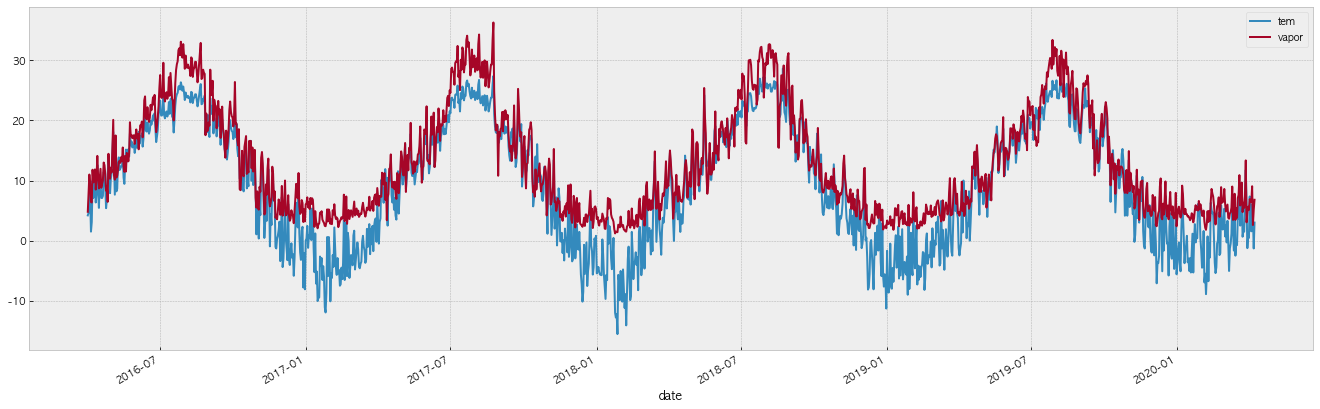

In [14]:
fig,ax=plt.subplots()
fig.set_size_inches(23,7)
hour4_30[['tem','vapor']].plot(ax=ax)
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# vapor변수 정상성 검증 
print( "검정통계량:" ,adfuller(hour4_30['vapor'])[0])
print( "p-value:" ,adfuller(hour4_30['vapor'])[1])
print( "사용된 시차의 수:" ,adfuller(hour4_30['vapor'])[2])
print( "자료의 수:" ,adfuller(hour4_30['vapor'])[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(hour4_30['vapor'])[4])

검정통계량: -1.8039995777484374
p-value: 0.3784778300590848
사용된 시차의 수: 12
자료의 수: 1455
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}


#### 정상화 Stationarize
* vapor변수 1차 차분후 정상화됨.

In [246]:
# 차분 후 정상성 검증 
diff_1=hour4_30['vapor'].diff(periods=1).iloc[1:]

print( "검정통계량:" ,adfuller(diff_1)[0])
print( "p-value:" ,adfuller(diff_1)[1])
print( "사용된 시차의 수:" ,adfuller(diff_1)[2])
print( "자료의 수:" ,adfuller(diff_1)[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(diff_1)[4])

검정통계량: -15.809107478386219
p-value: 1.0518618516792121e-28
사용된 시차의 수: 11
자료의 수: 1455
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}


**ARIMA모델에 exog인수 추가**
* ARIMAX모델에서는 auto arima 다르게 적용되는지 

In [61]:
# 외부 시계열의 영향을 포함하기 위한 exog 라는 인수
import statsmodels.api as sm
model = sm.tsa.ARIMA(hour4_30.tem,  exog=hour4_30.vapor,order=[2,1,1])   # auto arima로추정한 p,d,q = (2,1,1)
result = model.fit()
print(r2.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.tem   No. Observations:                 1466
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -3826.953
Method:                       css-mle   S.D. of innovations              3.283
Date:                Mon, 08 Jun 2020   AIC                           7665.907
Time:                        21:16:04   BIC                           7697.649
Sample:                    04-03-2016   HQIC                          7677.745
                         - 04-07-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0044      0.001      3.079      0.002       0.002       0.007
vapor           -0.0003      0.000     -3.114      0.002      -0.001      -0.000
ar.L1.D2.tem    -0.3525      0.025    -14.02

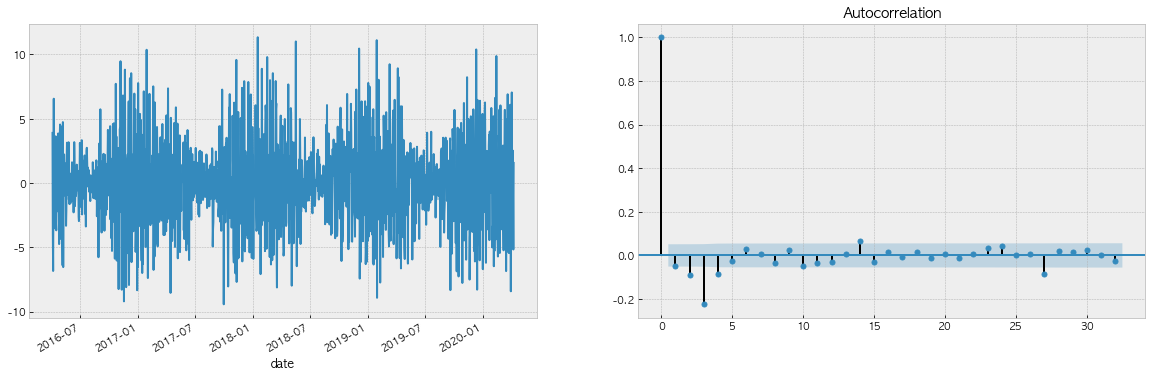

In [25]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(20,6)
result.resid.plot(ax=ax1)
sm.tsa.graphics.plot_acf(result.resid, ax=ax2)
plt.show()

#### pyflux패키지로 ARIMAX 적용
https://pyflux.readthedocs.io/en/latest/arimax.html

Normal ARIMAX(2,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: tem                                 Method: MLE                                       
Start Date: 2016-04-03 04:30:00                         Log Likelihood: -3419.3445                        
End Date: 2020-04-07 04:30:00                           AIC: 6850.6891                                    
Number of observations: 1466                            BIC: 6882.4309                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1174     0.0248     4.7323   0.0      (0.0688 | 0.166)         
AR(2)                                

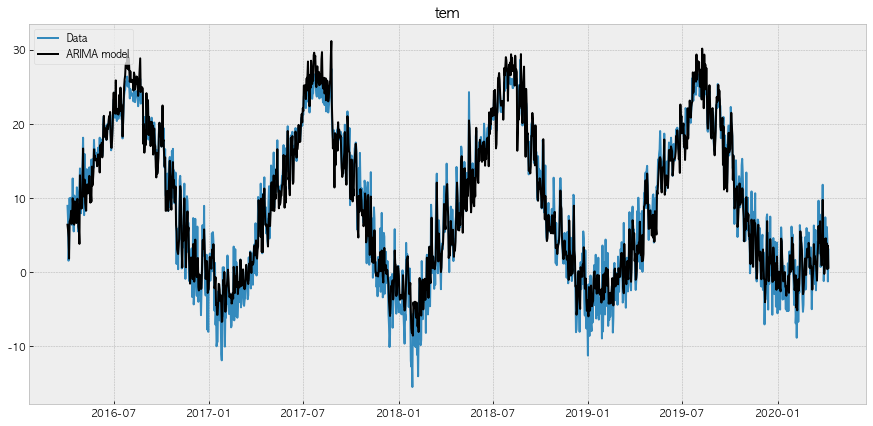

In [64]:
#  pyflux : ARIMAX 다른 패키지
import pyflux as pf
model = pf.ARIMAX(data=hour4_30, formula='tem~1+vapor',
                  ar=2, ma=1,family=pf.Normal())    # integ = 1 하면 1차차분 (ARIMAX에서는 차분 안한 결과가 더 좋음.)
x = model.fit("MLE")   # MLE = 최대우도추정. (maximum likelihood estimation)
x.summary()
model.plot_fit(figsize=(15,7))

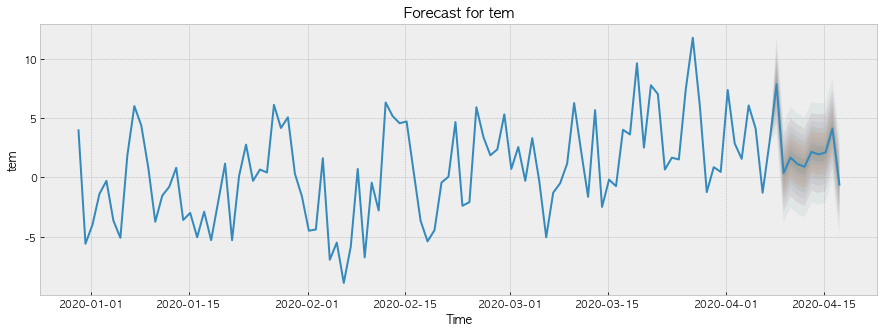

In [66]:
model.plot_predict(h=10, oos_data=hour4_30.iloc[-12:], past_values=100, figsize=(15,5))

In [101]:
hour4_30.iloc[:500]

,tem,vapor
date,,
2016-04-01 04:30:00,4.20,4.80
2016-04-02 04:30:00,4.60,7.70
2016-04-03 04:30:00,8.90,11.00
2016-04-04 04:30:00,7.15,9.35
2016-04-05 04:30:00,1.50,6.45
...,...,...
2017-08-09 04:30:00,23.45,28.20
2017-08-10 04:30:00,24.05,29.75
2017-08-11 04:30:00,22.50,27.10


In [ ]:
# 승한's
model_fit.predict(start = ('2017-08-15 04:30:00'), end = ('2020-04-07 04:30:00'),
                  exog = hour4_30.iloc[ i : period+i+1 ]['vapor'])

In [25]:
hour4_30.iloc[1466]['vapor']

5.1

In [135]:
hour4_30.shape[0]-1

1467

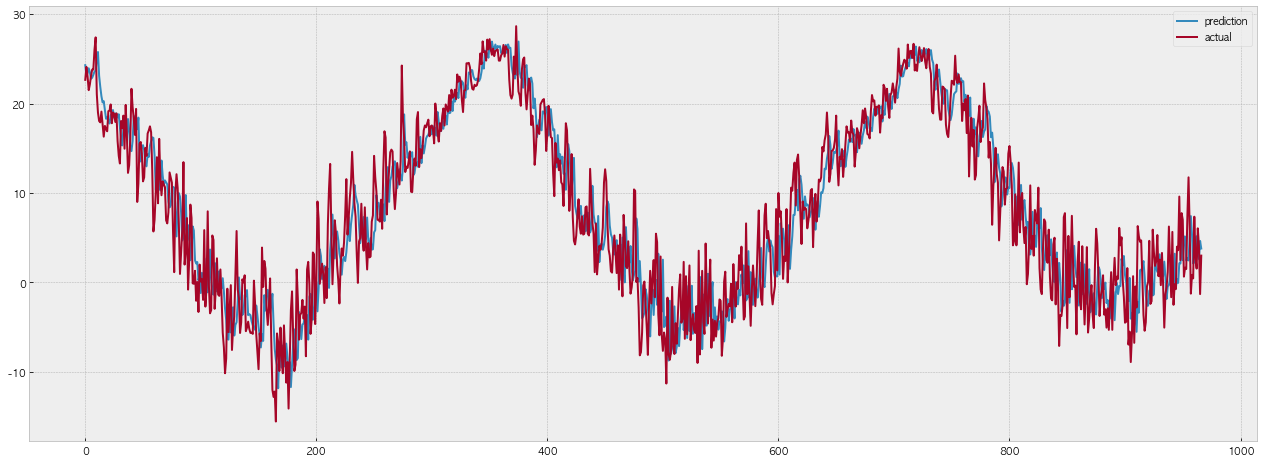

In [36]:
############################################## ARIMAX 모델에서는 exog 추가
"""
train시킬때는 exog값도 train과 동일한 범위를 넣고 학습시키고,
forecast할때는 예측할 시점의 exog값을 같이 넣어야 함. (ex. 0~500학습하고 501시점 예측한다면, 501시점의 exog값도 알고있어야 함)
"""

from statsmodels.tsa.arima_model import ARIMA
# i = 500,501,502,,,,1468
hour4_30=get_time_delta(seosan2,4,30)

prediction=[]
actual=[]
period=500
for i in range(0, hour4_30.shape[0]-500-1):   # i = 0~966 (총1467이지만 그전까지 예측해야하므로)
    train=hour4_30.iloc[ i: period+i]['tem']  # train= 0~500, 1~501, 2~502 ...(1466-500)=966~1466
    exog=hour4_30.iloc[i: period+i]['vapor']    # exog= train과 동일한 사이즈 (0~500, 1~501, 2~502 ...)
    test=hour4_30.iloc[period+(i+1)]['tem']  # 501, 502 ,503,,,,1467
    
    model =ARIMA(train,  exog=exog, order=[2,1,1])
    model_fit = model.fit()
    
    fore = model_fit.forecast( steps=1,exog=hour4_30.iloc[period+(i+1)]['vapor'])    # 예측할때 exog 범위 => test범위와 동일 
    prediction.append(fore[0][0])    # 예측값
    actual.append(test)      # 실제값

# prediction plot 과 실제값(test) plot 그리기.
fig,ax=plt.subplots()
fig.set_size_inches(22,8)
fig=plt.plot(prediction)
fig=plt.plot(actual)
plt.legend(['prediction','actual'])
plt.show()

In [37]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
print('rmse:',rmse(actual,prediction) )

# Calculate mean squared error 
print('mean_squared_error:',mean_squared_error(actual,prediction) )

rmse: 3.8535124480508984
mean_squared_error: 14.849558187283227
